# Import all the necessary modules
Make a conda environment and install Tensorflow 1.9.0, keras 2.1.6, OpenCV, and sklearn 

In [6]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers, regularizers
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage
from IPython.display import display, HTML
import time

In [8]:
TB_name = "shi_detect_VGG-16-{}".format(int(time.time()))

In [9]:
call_tensorboard = keras.callbacks.TensorBoard(log_dir='logs/{}'.format(TB_name))
#write_graph=True, write_images=True

# Lock the Random variables
.seed functions allow us to reproduce the same results for each random initialization
If the seed is set to the same number each time the program is run then the results of training the model will be the same

In [10]:
os.environ['PYTHONHASHSEED'] = '0' 
np.random.seed(10)
random.seed(10)
tf.set_random_seed(10)

helper function below for plotting images

In [11]:
def plots(ims, figsize = (12,6), rows = 1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

Path to directories containing the image data, and the list of classes

In [12]:
DATADIR = "/home/hamza/hamzamk/Keras_work/Ship_images"
#categories1 = ["cargo_RGB", "dredging_RGB",  "fishing_RGB",  "tanker_RGB",  "tug_RGB"]
categories = ["cargo", "tanker", "others"]

In [13]:
train_path = '/home/hamza/hamzamk/Keras_work/Ship_images/train'
valid_path = '/home/hamza/hamzamk/Keras_work/Ship_images/valid'
test_path = '/home/hamza/hamzamk/Keras_work/Ship_images/test'

In [14]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224, 224), color_mode='rgb', classes = categories, batch_size = 32, shuffle=True)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224, 224), color_mode='rgb',  classes = categories, batch_size = 30, shuffle=True)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224, 224),  color_mode='rgb', classes = categories, batch_size = 27, shuffle=True)

Found 11269 images belonging to 3 classes.
Found 140 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


Check the indices or lables assigned to each class by the ImageDataGenerator()

In [15]:
test_imgs, test_labels = next(test_batches)
class_labels = test_batches.class_indices
class_labels

{'cargo': 0, 'tanker': 1, 'others': 2}

Load the model and check its structure

In [16]:
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
type(vgg16_model)

keras.engine.training.Model

# Customizing VGG16
iterate over the layers to feed the sequential model, set trainable to False to benefit from the pre-trained weights.
Add layers to the model for fine tuning.

In [18]:
layers = []
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
    layers.append(layer)

model = Sequential(layers + [
    Conv2D(filters = 512, kernel_size = (7, 7), activation = 'relu'),
    #Conv2D(filters = 512, kernel_size = (4,4), activation = 'relu'),
    Flatten(),
    BatchNormalization(),
    Dense(4096, activation='relu'),
    Dense(2048, activation = 'relu'),
    Dropout(0.3),
    Dense(3, activation = 'softmax')
])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Model Compilation and Training

In [20]:
Adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.fit_generator(train_batches,
                   validation_data = valid_batches,
                   shuffle = True,
                   callbacks = [call_tensorboard],  
                   epochs = 33,
                   verbose = 1)

Epoch 1/33
353/353 [==============================] - 45s 126ms/step - loss: 0.7729 - acc: 0.7430 - val_loss: 0.8053 - val_acc: 0.6857
Epoch 2/33
353/353 [==============================] - 41s 117ms/step - loss: 0.6110 - acc: 0.7614 - val_loss: 0.7679 - val_acc: 0.7071
Epoch 3/33
353/353 [==============================] - 40s 114ms/step - loss: 0.5829 - acc: 0.7700 - val_loss: 0.8585 - val_acc: 0.6643
Epoch 4/33
353/353 [==============================] - 40s 112ms/step - loss: 0.5387 - acc: 0.7861 - val_loss: 0.7854 - val_acc: 0.7357
Epoch 5/33
353/353 [==============================] - 40s 115ms/step - loss: 0.4938 - acc: 0.8021 - val_loss: 0.7382 - val_acc: 0.7143
Epoch 6/33
353/353 [==============================] - 40s 114ms/step - loss: 0.4263 - acc: 0.8278 - val_loss: 0.9764 - val_acc: 0.7286
Epoch 7/33
353/353 [==============================] - 41s 116ms/step - loss: 0.3795 - acc: 0.8458 - val_loss: 0.5093 - val_acc: 0.8429
Epoch 8/33
353/353 [==============================] - 4

KeyboardInterrupt: 

# Running on test data for Predictions
The predictions will be displayed in scientific notation, e.g. 9.9989974e-01 in decimal is 0.99. This indicates high probability for the detected object

In [23]:
predictions = model.predict_generator(test_batches, verbose=1)

1/1 [==============================] - 1s 638ms/step


The code block below will only work if HTML and display have been imported in the first block, This will allow us to use CSS formating for comparitive content display on jupyter notebook. For viewing normal outputs, use the print function

In [24]:
CSS = """
.output{
    flex-direction: row;
    
}
"""
HTML('<style>{}</style>'.format(CSS))

In [25]:
display(predictions)
display(test_labels)

array([[1.6114444e-06, 9.6214590e-12, 9.9999833e-01],
       [1.0000000e+00, 3.2077778e-12, 4.5091265e-15],
       [9.9956304e-01, 1.7662467e-04, 2.6033030e-04],
       [1.7849238e-04, 4.3069616e-05, 9.9977845e-01],
       [9.5152724e-01, 2.3473077e-02, 2.4999732e-02],
       [3.7061454e-06, 9.9953830e-01, 4.5804479e-04],
       [1.0000000e+00, 6.4009836e-10, 9.2594812e-13],
       [6.9896792e-08, 2.8171081e-08, 9.9999988e-01],
       [4.2317063e-03, 9.9468404e-01, 1.0842247e-03],
       [8.7164764e-10, 3.4707792e-11, 1.0000000e+00],
       [3.2371517e-08, 1.0897545e-08, 1.0000000e+00],
       [5.8430567e-07, 6.3363387e-07, 9.9999881e-01],
       [9.9914038e-01, 8.4847101e-04, 1.1086841e-05],
       [7.9241392e-05, 9.1910057e-05, 9.9982882e-01],
       [9.8185229e-01, 2.6360898e-05, 1.8121421e-02],
       [6.4109099e-07, 5.6030625e-08, 9.9999928e-01],
       [2.8406311e-04, 1.9633686e-02, 9.8008221e-01],
       [9.7389865e-01, 2.0049054e-02, 6.0523096e-03],
       [9.4019639e-01, 5.978

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

# Plotting Confusion Matrix function 
Sklearn function 'confusion_matrix(y_true, y_pred)' requires two array arguements with class labels in decimals. The two arrays are true labels and predictions. The function below maps the probabilitiesn or one hot encoded arrays to the required array format

In [26]:
def predictions_to_label_array(predictions_array):
    predictions_one_hot_encode = []
    for array in predictions_array:
        result_per__iteration = []
        for value in array:
            if value < max(array):
                result_per__iteration.append(0)
            elif value == max(array):
                result_per__iteration.append(1)
            else:
                result_per__iteration.append(0)
        predictions_one_hot_encode.append(result_per__iteration)
    return([np.where(r==1)[0][0] for r in np.array(predictions_one_hot_encode)])
prediction_label = predictions_to_label_array(predictions)
true_label = predictions_to_label_array(test_labels)
print('{}\n{}\n{}'.format(class_labels, true_label, prediction_label))

{'cargo': 0, 'tanker': 1, 'others': 2}
[2, 0, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 1]
[2, 0, 0, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 1]


In [27]:
cm = confusion_matrix(true_label, prediction_label)

This function has been copied from the Sklearn confusion matrix page

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.show()

Confusion matrix, without normalization
[[6 0 0]
 [2 2 0]
 [1 1 9]]
Confusion matrix, without normalization
[[6 0 0]
 [2 2 0]
 [1 1 9]]


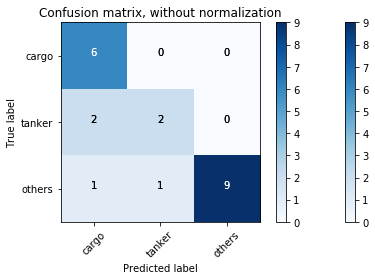

In [29]:
cm_plot_labels = categories
plot_confusion_matrix(cm, cm_plot_labels,
                          title='Confusion matrix')

plot_confusion_matrix(cm, classes=categories,
                      title='Confusion matrix, without normalization')

# Generate Classification Report

In [30]:
print(classification_report(true_label, prediction_label, target_names=categories))

             precision    recall  f1-score   support

      cargo       0.67      1.00      0.80         6
     tanker       0.67      0.50      0.57         4
     others       1.00      0.82      0.90        11

avg / total       0.84      0.81      0.81        21



# Saving the model
The method below will only work if keras version 2.1.6 or below is used

In [31]:
model.save('saved_models/vgg16_model_ships.h5')#The architecture, weights, congig, state

In [32]:
new_model = load_model('saved_models/vgg16_model_ships.h5')